<a href="https://colab.research.google.com/github/zsnoori/NMA_DL_FER/blob/master/NMA_DL_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognision
## Nueromatch Academy- Deep Learning course
## Summer 2023
## Pod name: Belausarus
## Group 2
- Mohammad ([email](mailto:alaeimono@gmail.com) | [GitHub](https://github.com/alaeimo) | [linkedin](https://linkedin.com/in/...) )
- Zahra ([email](mailto:zs.noori@gmail.com) | [GitHub](https://github.com/zsnoori) | [linkedin](https://linkedin.com/in/zsnoori) )
- Rishabh ([email](mailto:rishabhbapat@gmail.com) | [GitHub](https://github.com/...) | [linkedin](https://linkedin.com/in/...) )
- Vahid ([email](mailto:m1vahid@gmail.com) | [GitHub](https://github.com/...) | [linkedin](https://linkedin.com/in/...) )

## Prepare the requierments

In [2]:
# @title Install dependencies
%%capture
!pip install torchinfo

In [3]:
# @title Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo import summary
from tqdm import tqdm

In [4]:
# @title Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [6]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
set_seed(seed=2021)
device = set_device()


Random seed 2021 has been set.


## Load and Prepare Dataset

In [8]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
emotions_inv = {v:k for k,v in emotions.items()}

In [9]:
# @title Dataset class
# @markdown FER2013 dataset includes 3 types of samples, Training, PublicTest, and PrivateTest. This class loads data of each part.

class FER2013(Dataset):
    def __init__(self, csv_file:str, split:str='Training', transforms:transforms.Compose=None):
      """
      Arguments:
          csv_file (string): Path to the FER2013 icml_face_data.csv file with annotations.
          split = 'Training' for train , 'PublicTest' for validation, 'PrivateTest' for test
          transform (callable, optional): Optional transform to be applied on a sample.
      """
      self._main_df = pd.read_csv(csv_file)
      self.split = split
      self.transforms = transforms
      self._samples = self._load()

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        img, label = self._samples[idx]
        img = torch.as_tensor(img).float()
        if self.transforms:
            img = self.transforms(img)
        return img, label

    def _load(self):
      df = self._main_df
      df.columns = df.columns.str.replace(' ', '')
      df = df[df['Usage'] == self.split].copy()
      samples = []
      for index, row in df.iterrows():
          label = row['emotion']
          img_arr = row['pixels'].split(' ')
          img_arr = np.array(img_arr).astype(int)
          img_arr = img_arr.reshape(48,48)
          samples.append((img_arr, label))
      samples = np.array(samples, dtype=object)
      return samples

In [ ]:
# @title Define batch size and dataset path
batch_size = 32
dataset_csv_file = "./drive/MyDrive/Colab Notebooks/datasets/fer2013/icml_face_data.csv"

In [ ]:
# @title Transformations
torchvision_transforms = True  # True/False if you want use torchvision augmentations
# Define the transformations to apply
transforms_train = transforms.Compose([transforms.ToPILImage()])
if torchvision_transforms:
    transforms_train.transforms.extend([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=48, padding=4)])

transforms_train.transforms.extend([
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor()])

transforms_validation = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor()])

transforms_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])


In [ ]:
# @title Load data
# @markdown create 3 dataloaders to load Training, validation, and test data.
# Create the dataset
train_dataset = FER2013(csv_file=dataset_csv_file, split='Training', transforms=transforms_train)
validation_dataset = FER2013(csv_file=dataset_csv_file, split='PublicTest', transforms=transforms_validation)
test_dataset = FER2013(csv_file=dataset_csv_file, split='PrivateTest', transforms=transforms_test)

# Create the data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Plot some samples



In [ ]:
# @title Plotting methods
# @markdown Plot dataset images (before transformation) and dataloader images (after transformation)
def show_dataloader_batch(dataloader):
  batch = next(iter(dataloader))
  # Extract the images and labels from the batch
  images, labels = batch
  # fig = plt.figure(figsize=(10, 10))
  for i in range(len(images)):
      ax = plt.subplot(4,len(images)//4 + 1, i+ 1)
      image = images[i]
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[labels[i].item()]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def show_dataset_batch(dataset, batch_size=20):
  for i in range(batch_size):
      image, label = dataset._samples[i]
      ax = plt.subplot(4, batch_size//4 + 1, i+ 1)
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[label]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

Train Dataset Samples


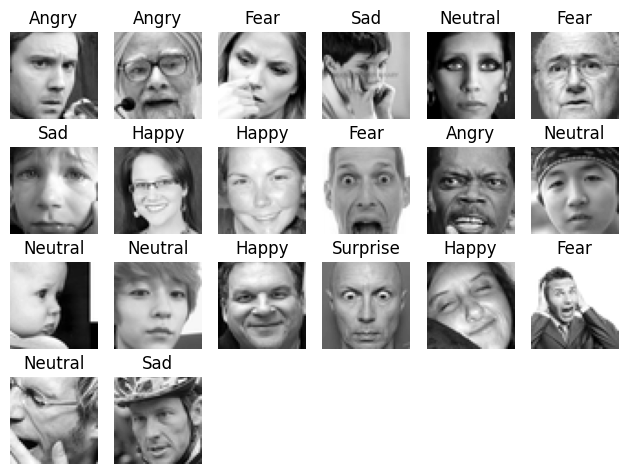

Transformed Train Dataset Samples


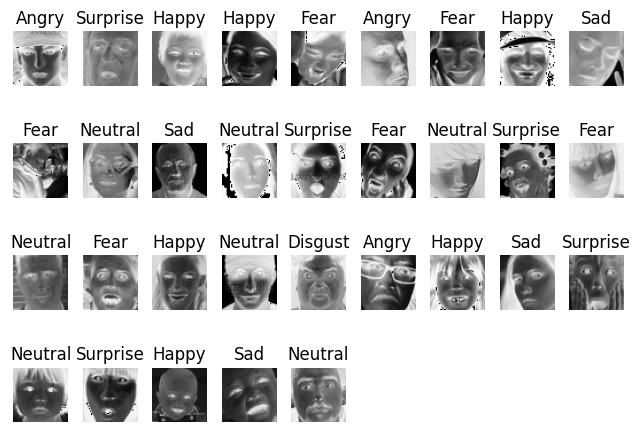

In [ ]:
print("Train Dataset Samples")
show_dataset_batch(train_dataset)
print("Transformed Train Dataset Samples")
show_dataloader_batch(test_dataloader)

In [ ]:
#Preprocessing
# Face Alignment

## Models


Pretrained models are models that have been trained on large datasets. By utilizing their learned weights, we can enhance our own models. We can modify or add layers to the pretrained model, enabling us to train a smaller number of parameters during our own training process. This approach helps to leverage existing knowledge and accelerate model training.

### Architecture 01: ResNet


ResNet (Residual Network) is a deep learning architecture that addresses the challenge of training very deep neural networks. It introduces residual connections, or skip connections, which allow information to flow directly across layers. This helps mitigate the degradation problem, where the performance of deeper networks decreases due to vanishing gradients. ResNet's residual connections enable the training of extremely deep networks, achieving state-of-the-art performance in various computer vision tasks, such as image classification and object detection.

In [ ]:
# @title Define ResNet model and download pre-trained weights
resnet_model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze Layers
for param in resnet_model.parameters():
  param.requires_grad = False

# Display model summary
summary(resnet_model, input_size=(1, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 24, 24]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 24, 24]           (128)
├─ReLU: 1-3                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-4                         [1, 64, 12, 12]           --
├─Sequential: 1-5                        [1, 64, 12, 12]           --
│    └─BasicBlock: 2-1                   [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-1                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-4                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 12, 12]   


Once the weights have been downloaded, we proceed to modify specific layers as needed. By doing so, we can observe the impact on the accuracy of both the training and validation data.

#### 01-01- Changing the last Layer:
Since ResNet classifies images in 1000 classes and FER2013 has 7 classes, we changed the last layer.

In [ ]:
# Change the last Layer:
resnet_model.fc = torch.nn.Linear(in_features=512, out_features=7)
resnet_model.softmax = torch.nn.Softmax(dim=1)
# Display model summary
summary(resnet_model, input_size=(1, 3, 48, 48))

In [ ]:
# @title Hyperparameters
base_learning_rate = 1e-4
best_acc = 0

##### Define requiered methods

In [ ]:
# @title checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, out_model_name):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{out_model_name}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [ ]:
# @title train & test
def train(net, epoch, use_cuda=True, pbar=None):
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  # pbar = tqdm(enumerate(train_dataloader))
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    result = f"Epoch:{epoch} Training-Batch: {batch_idx}/{len(train_dataloader)}| Loss: {(train_loss/(batch_idx+1)):0.3f} | Acc: {(100.*correct/total):0.3f}"
    pbar.set_description(result)
  return (train_loss/batch_idx, 100.*correct/total)

def test(net, epoch, out_model_name, use_cuda=True, pbar=None):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(validation_dataloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()
      result = f"Epoch:{epoch} Testing-Batch: {batch_idx}/{len(validation_dataloader)}| Loss: {(test_loss/(batch_idx+1)):0.3f} | Acc: {(100.*correct/total):0.3f}"
      pbar.set_description(result)

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
    checkpoint(net, acc, epoch, out_model_name)
  return (test_loss/batch_idx, 100.*correct/total)

In [ ]:
# @title History class to save accuracy and loss during the training process
class History:
  def __init__(self):
    self.train_acc = []
    self.validation_acc = []
    self.test_acc = []
    self.train_loss = []
    self.validation_loss = []
    self.test_loss = []

  def append_results(self, loss, acc, split):
    if split == "train":
      self.train_loss.append(loss)
      self.train_acc.append(acc)
    if split == "validation":
      self.validation_loss.append(loss)
      self.validation_acc.append(acc)
    if split == "test":
      self.test_loss.append(loss)
      self.test_acc.append(acc)

In [ ]:
# @title Plot Accuarcy and Loss dusring the trainig process
def plot_history(history):
  # Plotting
  plt.figure(figsize=(10,3))
  ax = plt.subplot(1,2,1)
  ax.plot(history.train_loss)
  ax.plot(history.test_loss)
  ax.set_title("Loss")
  ax.legend(["train_loss", "test_loss"])
  ax = plt.subplot(1,2,2)
  ax.plot(history.train_acc)
  ax.plot(history.test_acc)
  ax.set_ylim(0,100)
  ax.set_title("Accuracy")
  ax.legend(["train_acc", "test_acc"])
  plt.tight_layout()
  plt.show()

##### Train the model

In [ ]:
# @title Set loss function and optimizer
# Optimizer and criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

In [ ]:
# @title Training
start_epoch = 0
max_epochs = 10
use_cuda = True
out_model_name = "resnet18"
history = History()
pbar = tqdm(range(start_epoch, max_epochs))
for epoch in pbar:
  # adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(resnet_model, epoch, use_cuda=use_cuda, pbar=pbar)
  history.append_results(train_loss, train_acc, "train")
  test_loss, test_acc = test(resnet_model, epoch, out_model_name, use_cuda=use_cuda, pbar=pbar)
  history.append_results(test_loss, test_acc, "test")
  print(f'  Epoch:{epoch + 1} | Train acc: {train_acc} | Test acc: {test_acc}')

##### Result of runs with different learning rates

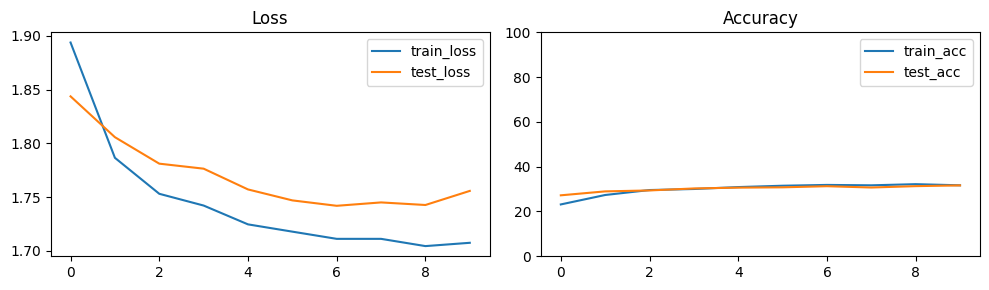

In [ ]:
# @title lr=1e-4
# plot_history(history)

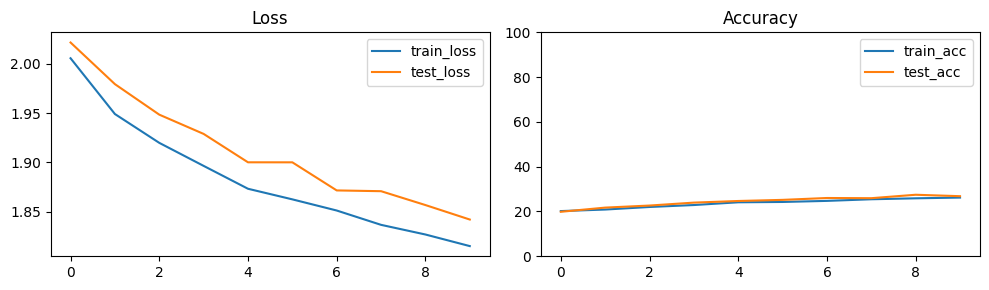

In [ ]:
# @title lr=1e-5
# plot_history(history)

#### 01-02- Changing the last fully connected sequensial


In [ ]:
resnet_model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(128, 7),
    torch.nn.Softmax(dim=1)
)
summary(resnet_model, input_size=(1, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 24, 24]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 24, 24]           (128)
├─ReLU: 1-3                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-4                         [1, 64, 12, 12]           --
├─Sequential: 1-5                        [1, 64, 12, 12]           --
│    └─BasicBlock: 2-1                   [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-1                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 12, 12]           --
│    │    └─Conv2d: 3-4                  [1, 64, 12, 12]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 12, 12]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 12, 12]   